In [9]:
%matplotlib inline
import pandas as pd
import os
import xlrd

kwargs = [
{'io': 'school/ClassSizebyGenPopulation.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/enrollmentbygrade.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/enrollmentbyracegender.xlsx', 'header': 4, 'index_col': 0},
{'io': 'school/Gradsattendingcollege.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/mcas.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/PerPupilExpenditures.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/sat_performance.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/ssdr.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/TeacherSalaries.xlsx', 'header': 1, 'index_col': 0},
{'io': 'school/SelectedPopulations.xlsx', 'header': [4,5], 'index_col': 0},

]
schooldata = []
districtdata = []
for kw in kwargs:
    df = pd.read_excel(**kw)
    if type(kw['header']) == list:
        df.columns = df.columns.map('{0[0]}{0[1]}'.format)
    # uncomment to check all column headers
    # print(df.columns)
    
    if df.columns[0][0] == 'D':
        districtdata.append(df)
    else:
        schooldata.append(df)
        

In [10]:
# split the index to add a SAChool and Town column
newcols = pd.DataFrame(schooldata[0].index.str.split(' - ',1).tolist(), columns = ['Town','School'], index=schooldata[0].index)
schooldata.append(newcols)
df = pd.concat(schooldata, axis=1)
df = df.loc[:, ~df.columns.duplicated()]
# optionally drop this stray column.
# df = df.drop('Unnamed: 9', axis=1)

# clean up column headers to allow queries
df.columns = [c.replace(' ','').replace('%',"Percent").replace('-','').replace('#', 'Num') for c in df.columns]



In [11]:
def town(name):
    """return sub dir with town name"""
    return df[df['Town']==name]


In [34]:

quincy = town("Lexington")
pd.set_option("display.max_columns", len(df.columns))

# crude way to filter diversity
# quincy.eval("White < 60 & Hispanic < 60 & AfricanAmerican < 60 & Asian < 60")

quincy.to_csv("quincy.csv")


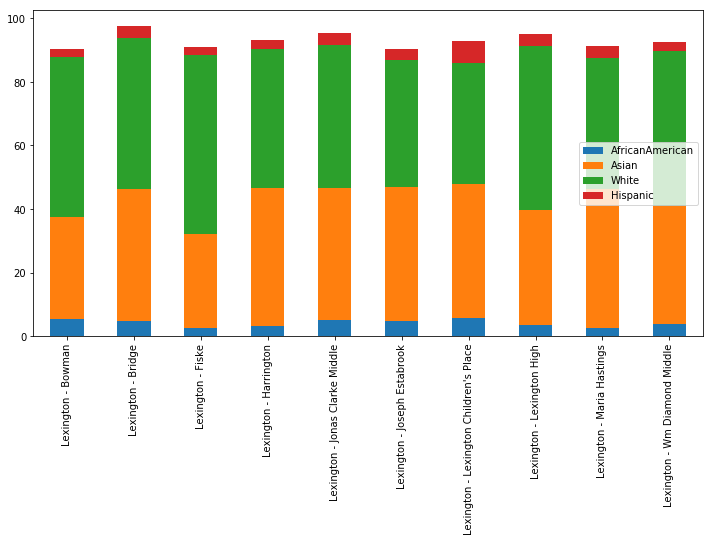

In [35]:
quincy[['AfricanAmerican','Asian','White','Hispanic']].plot.bar(stacked=True, figsize=(12, 6));

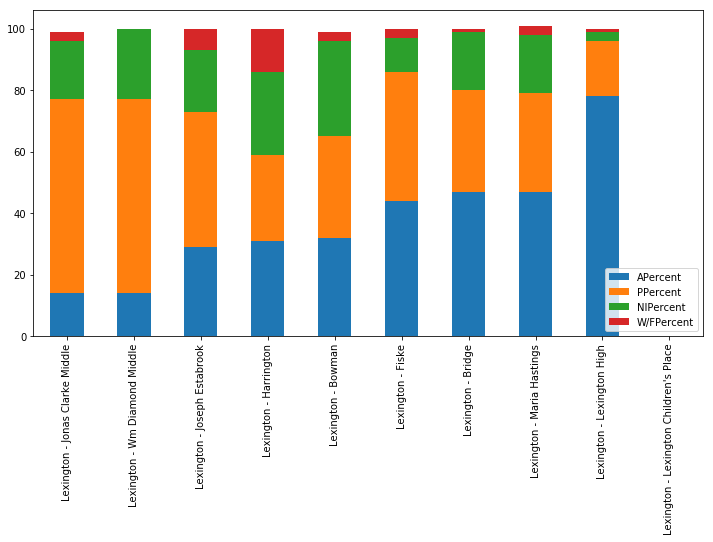

In [36]:
quincy[['APercent', 'PPercent', 'NIPercent', 'W/FPercent']].sort_values('APercent').plot.bar(stacked=True, figsize=(12, 6))

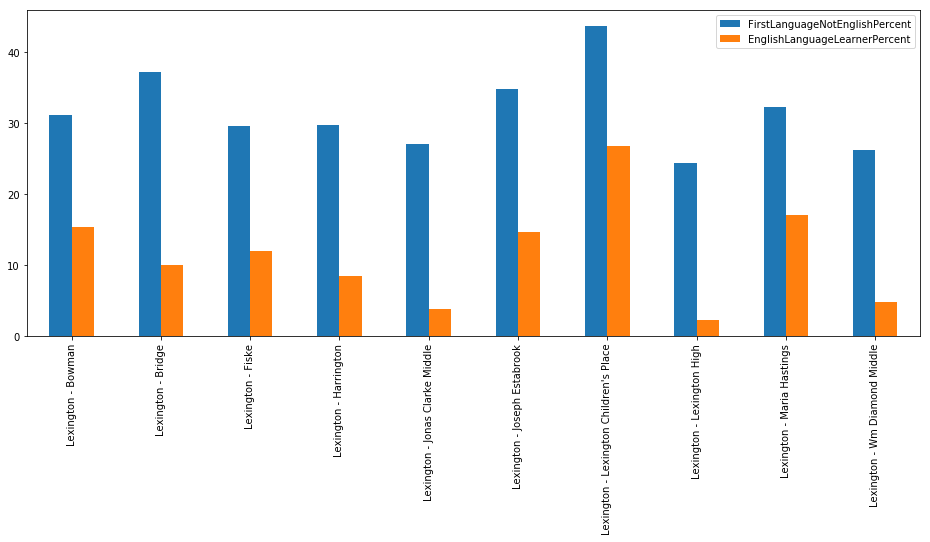

In [37]:
quincy[['FirstLanguageNotEnglishPercent', 
       'EnglishLanguageLearnerPercent', 
       ]].plot.bar(stacked=False, figsize=(16, 6))

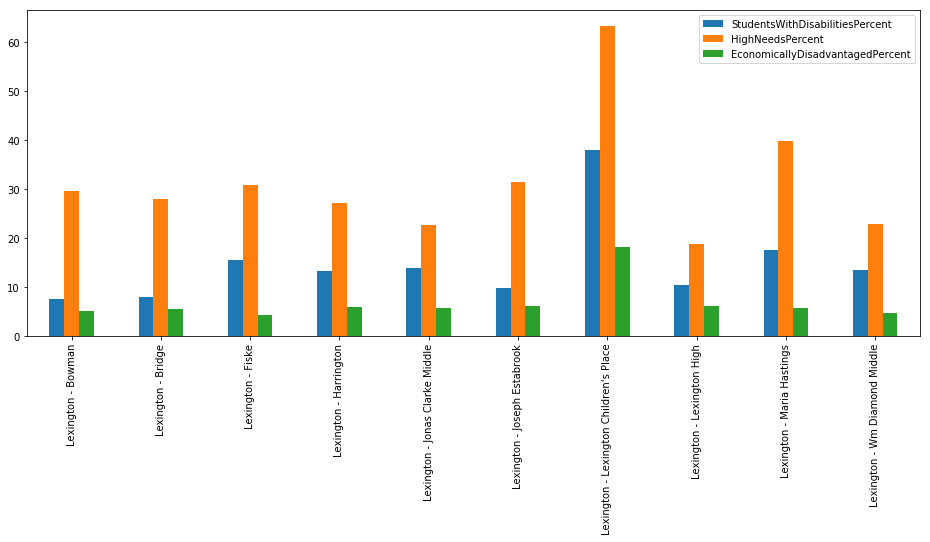

In [38]:
quincy[['StudentsWithDisabilitiesPercent', 'HighNeedsPercent',
        'EconomicallyDisadvantagedPercent']].plot.bar(stacked=False, figsize=(16, 6))
